In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Librerias

In [ ]:
import re, string, unicodedata
import numpy as np
import pandas as pd
import pickle
import collections

import nltk
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords


%pip install stanza
import stanza


In [ ]:
download('stopwords')
download('punkt')
stanza.download('es')
nlp = stanza.Pipeline('es')

In [ ]:
def eliminar_textos_basura(texto):
    # eliminar emojis: elimina todo lo que este en <>. 
    texto_procesado = re.sub('<.*?>', ' ', texto)
    # convertir a minusculas
    texto_procesado = texto_procesado.lower()
    # remover @usuario
    texto_procesado = re.sub('@[^\s]+',' ',texto_procesado)
    # remover RT
    texto_procesado = re.sub('rt   ',' ',texto_procesado)
    texto_procesado = re.sub('rt',' ',texto_procesado)
    texto_procesado = re.sub('rt ',' ',texto_procesado)
    # remover numeros
    texto_procesado = re.sub("\d+", "", texto_procesado)
    # texto_procesado = re.sub(r'http\S+', ' ', texto_procesado)
    texto_procesado = re.sub("(\w+:\/\/\S+)", " ", texto_procesado)
    # reemplazar todos los caracteres que no saen alfanuméricos con espacios
    texto_procesado = re.sub(r'[^a-zA-Z0-9ÑñÁáÉéÍíÓóÚú\s]', ' ', texto_procesado)
    
    return texto_procesado

def eliminar_stop_words(texto):
    # obtener lista de stopwords
    stop_words = set(stopwords.words('spanish')) 
    stop_words.remove('no')
    #separar el texto por palabras
    palabras = word_tokenize(texto) 
    # dejar solo palabras que no sean stopwords
    texto_sin_sw = [w for w in palabras if not w in stop_words] 
    #  convertir en una sola cadena la lista de palabras
    texto_sin_sw = ' '.join(texto_sin_sw)

    return texto_sin_sw 

def remove_non_ascii(word):
    """Remueve caracteres no ASCII"""
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    return new_word

def establecer_lema(text):
  doc = nlp(text)
  new = ''
  for sent in doc.sentences:
    for word in sent.words:
      new = new + word.lemma
      new = new + ' '

  return new

#Convierto cada tweet del dataset en un vector de palabras
from nltk import word_tokenize
def ConvertirData(corpusBase):
  textos = []
  for y in [corpusBase['text'][i] for i in range(len(corpusBase))]:
      doc = word_tokenize(y)
      textos.append(doc)
  return textos

def convertirDataWord2Vec(data):
  comments = []
  for line in DataFinal['text']:
      comments.append(str(line).split(' '))
  return comments

In [ ]:
def Knn(Matriz, k):
  labels = DataFinal['tipo']
  pred_label = []
  etiquetar = []
  indice = 0
  for x in labels:
      if(indice != len(labels)-1):
        if(Matriz[indice]<=0.20): #Filtro que asigan directament 0 cuando el valor de comparacion sera cero o menor a cero
          etiquetar.append((Matriz[indice], 0))
        else:
          etiquetar.append((Matriz[indice], x))
      indice += 1
  etiquetar.sort(reverse=True)
  neighbors = etiquetar[:k]
  votes = []
  for neighbor in neighbors:
            votes.append(neighbor[1])
  counter = collections.Counter(votes) #Determina el que mas se repite
  pred_label.append(counter.most_common()[0][0])
  return pred_label

def EtiquetaEnTexto(valor):
  if valor[0]==1:
    return 'emergencia'
  else:
    return 'no emergencia'

In [ ]:
def ProcesarTweet(Tweet):
  Procesado = eliminar_textos_basura(Tweet)
  Procesado = eliminar_stop_words(Procesado)
  Procesado = remove_non_ascii(Procesado)
  Procesado = establecer_lema(Procesado)
  return Procesado

RECURSO

In [ ]:
DataFinal = pd.read_excel('/content/gdrive/My Drive/ART_EMERGENCY/GLOVE_CODIGO/4DataFinalLemaFiltro.xlsx')

CREACIÓN DEL MODELO 


In [ ]:
from gensim.models import Word2Vec

In [ ]:
'''
Función que recibira el tweet para generar las comparaciones con los tweets de la data en base al modelo
'''
def modeloWord2Vec(tweet):
  Tweet = ProcesarTweet(tweet) #Se Preprocesa el tweet y se tokeniza el texto
  #Tweet = tweet
  if len(Tweet.split()) <= 2: #Se valida que el tweet preprocesado tenga un minino de palabras
    Tweet = 'falso'  #Se le asigna el texto 'vacio' el cual sera detectado como no emergencia

  eje_vectors =  np.mean([word2vec_model.wv[word] for word in Tweet.split() if word in word2vec_model.wv.vocab], axis=0)
  sim=[]

  for i in data_vector:
    similarity = (i @ eje_vectors) / (np.linalg.norm (i) * np.linalg.norm (eje_vectors)) 
    sim.append(similarity)

    
  Valor_Similitud = [] 
  for i in range(len(sim)):
    a = ('%.2f' % sim[i]) #Se redondea cada valor del vector de similitud creado para establecer un mismo formato a todos los valores
    Valor_Similitud.append(float(a))
  
  return sim

In [ ]:
'''
Determina la etiqueta del nuevo tweet por cada knn establecido
'''
def EtiquetarModelWord2Vec(tweet):
  Similaridad= modeloWord2Vec(tweet)
  k_1 = Knn(Similaridad, 1)
  k_3 = Knn(Similaridad, 3)
  k_5 = Knn(Similaridad, 5)
  k_7 = Knn(Similaridad, 7)
  k_9 = Knn(Similaridad, 9)
  k_11 = Knn(Similaridad, 11)
  return k_1, k_3, k_5, k_7, k_9, k_11 

In [ ]:
'''
En consideración a que el modelo cada que se crea genera resultados diferentes, se establece la creación de 12 variantes 
'''
textos = convertirDataWord2Vec(DataFinal) #Se tokeniza cada tweet de la data
for a in range(12):
  #Creación del modelo
  model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_count= 1 , min_alpha=0.0007,
                 seed = 14)


  model.build_vocab(textos, progress_per=200)
  model.train(textos, total_examples = model.corpus_count, 
              epochs=10, report_delay=1)
  
  text1='/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/MODELO/ModelWord2Vec'+str(a)+'.model'

  pickle.dump(model, open(text1, 'wb'))

  print('MODELO CREADO WORD2VEC '+str(a))

PRUEBAS DE LAS VARIANTES DEL MODELO

In [ ]:
import pandas as pd
import numpy as np
import collections
from sklearn import datasets, metrics

def EmplearMetricasDeValidacion(DataPrueba, Modelo, columnas):
  metric1 = []
  metric2 = []
  metric3 = []
  metric4 = []
  metric5 = []

  re = GenerarResultadosModelo(DataPrueba, Modelo)
  #k1
  metric1.append(metrics.accuracy_score(re[0], re[1]))
  metric2.append(metrics.precision_score(re[0], re[1]))
  metric3.append(metrics.recall_score(re[0], re[1]))
  #metric4.append(metrics.f1_score(re[0], re[1]))
  metric5.append(metrics.log_loss(re[0], re[1]))
  #k3
  metric1.append(metrics.accuracy_score(re[0], re[2]))
  metric2.append(metrics.precision_score(re[0], re[2]))
  metric3.append(metrics.recall_score(re[0], re[2]))
  #metric4.append(metrics.f1_score(re[0], re[2]))
  metric5.append(metrics.log_loss(re[0], re[2]))
  #k5
  metric1.append(metrics.accuracy_score(re[0], re[3]))
  metric2.append(metrics.precision_score(re[0], re[3]))
  metric3.append(metrics.recall_score(re[0], re[3]))
  #metric4.append(metrics.f1_score(re[0], re[3]))
  metric5.append(metrics.log_loss(re[0], re[3]))
  #k7
  metric1.append(metrics.accuracy_score(re[0], re[4]))
  metric2.append(metrics.precision_score(re[0], re[4]))
  metric3.append(metrics.recall_score(re[0], re[4]))
  #metric4.append(metrics.f1_score(re[0], re[4]))
  metric5.append(metrics.log_loss(re[0], re[4]))

  #k9
  metric1.append(metrics.accuracy_score(re[0], re[5]))
  metric2.append(metrics.precision_score(re[0], re[5]))
  metric3.append(metrics.recall_score(re[0], re[5]))
  #metric4.append(metrics.f1_score(re[0], re[5]))
  metric5.append(metrics.log_loss(re[0], re[5]))

  #k11
  metric1.append(metrics.accuracy_score(re[0], re[6]))
  metric2.append(metrics.precision_score(re[0], re[6]))
  metric3.append(metrics.recall_score(re[0], re[6]))
  #metric4.append(metrics.f1_score(re[0], re[6]))
  metric5.append(metrics.log_loss(re[0], re[6]))

  resultado=[metric1,metric2,metric3,metric5]

  Final = pd.DataFrame(resultado,columns=columnas)
  Final.insert(0,"METRICAS VALIDACION",['ACURRACY_SCORE','PRECISIÓN_SCORE','RECALL_SCORE','LOG_LOSS'],True)
  
  return Final

def GenerarResultadosModelo(DataN, modelo):
  Data = DataN
  Reemplazo = Data['tipo'].replace(['emergencia'], 1).replace(['no emergencia'], 0)
  Data['tipo'] = Reemplazo
  text = list(Data['New_Tweet'])
  
  prediccion1 = []
  prediccion2 = []
  prediccion3 = []
  prediccion4 = []
  prediccion5 = []
  prediccion6 = []

  for a in text:
    metodo= modelo(a)
    prediccion1.append(metodo[0])
    prediccion2.append(metodo[1])
    prediccion3.append(metodo[2])
    prediccion4.append(metodo[3])
    prediccion5.append(metodo[4])
    prediccion6.append(metodo[5])
  test_final = list(Data['tipo'])

  return  test_final, prediccion1, prediccion2, prediccion3, prediccion4, prediccion5, prediccion6 

In [ ]:
#Generar Reportes que contengan los resultados de las metricas de validación de cada una de las variantes del modelo
import pickle
DataNivelada = pd.read_excel('/content/gdrive/My Drive/ART_EMERGENCY/GLOVE_CODIGO/New_DataPrueba_Total.xlsx')

Data = []

indice = 6
for a in range(6):
  
  txt1='/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/MODELO/ModelWord2Vec'+str(indice)+'.model'

  word2vec_model = pickle.load(open(txt1,'rb'))

  data_vector = []

  for comment in DataFinal['text']:
    words_vectors = np.mean([word2vec_model.wv[word] for word in comment.split() if word in word2vec_model.wv.vocab], axis=0)
    # Aqui puedes promediar los vectores de las palabras o utilizar otra técnica para representar al comentario
    data_vector.append(words_vectors)

  WORD2VEC = EmplearMetricasDeValidacion(DataNivelada, EtiquetarModelWord2Vec, ['word2vec_1','word2vec_3','word2vec_5','word2vec_7','word2vec_9','word2vec_11'])
  txtData = 'Verificacion_Modelo_Word2Vec_'+str(indice)+'.xlsx'
  print('ENTRO: ',indice)
  Data.append(WORD2VEC)
  indice = indice + 1

In [ ]:
#Guardar Reportes, el cual contara con las metricas de validación de cada uno de las variantes del modelo
Data[0].to_excel('Verificacion_Modelo_Word2Vec_0.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_0.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[1].to_excel('Verificacion_Modelo_Word2Vec_1.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_1.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[2].to_excel('Verificacion_Modelo_Word2Vec_2.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_2.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[3].to_excel('Verificacion_Modelo_Word2Vec_3.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_3.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[4].to_excel('Verificacion_Modelo_Word2Vec_4.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_4.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[5].to_excel('Verificacion_Modelo_Word2Vec_5.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_5.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[6].to_excel('Verificacion_Modelo_Word2Vec_6.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_6.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[7].to_excel('Verificacion_Modelo_Word2Vec_7.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_7.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[8].to_excel('Verificacion_Modelo_Word2Vec_8.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_8.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[9].to_excel('Verificacion_Modelo_Word2Vec_9.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_9.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[10].to_excel('Verificacion_Modelo_Word2Vec_10.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_10.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'

Data[11].to_excel('Verificacion_Modelo_Word2Vec_11.xlsx', index=False)
!cp Verificacion_Modelo_Word2Vec_11.xlsx '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'



GENERAR CURVA

AUC - Test Set: 88.98%


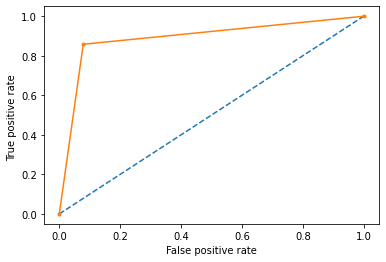

In [ ]:
#LIBRERIAS
import warnings
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

DataNivelada = pd.read_excel('/content/gdrive/My Drive/ART_EMERGENCY/GLOVE_CODIGO/New_DataPrueba_Total.xlsx')

txt1='/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/MODELO/ModelWord2Vec2.model'
word2vec_model = pickle.load(open(txt1,'rb'))

data_vector = []

for comment in DataFinal['text']:
    words_vectors = np.mean([word2vec_model.wv[word] for word in comment.split() if word in word2vec_model.wv.vocab], axis=0)
    data_vector.append(words_vectors)

re_Word2vec = GenerarResultadosModelo(DataNivelada, EtiquetarModelWord2Vec)

y_test = re_Word2vec[0]
y_pred = re_Word2vec[6]

auc = roc_auc_score(y_test, y_pred)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate ')
# show the plot
plt.show()

Análisis de Resultados para determinar la mejor variante del Modelo




In [ ]:
#Cargar los resultados de validación de las variantes del modelo
DataModel = []
for a in range(6): 
  txt = 'Verificacion_Modelo_Word2Vec_'+str(a)+'.xlsx'
  txt2= '/content/gdrive/My Drive/ART_EMERGENCY/WORD2VEC_CODIGO/ANALIZAR/'+txt
  DataModel.append(pd.read_excel(txt2)) 

In [ ]:
Word2Vec_5 = []
Word2Vec_7 = []
Word2Vec_9 = []
Word2Vec_11 = []
for a in range(6):
  Word2Vec_5.append([DataModel[a]['word2vec_5'][0],a])
  Word2Vec_7.append([DataModel[a]['word2vec_7'][0],a])
  Word2Vec_9.append([DataModel[a]['word2vec_9'][0],a])
  Word2Vec_11.append([DataModel[a]['word2vec_11'][0],a])


In [ ]:
Word2Vec_5.sort(reverse=True)
Word2Vec_5

[[0.88375, 3],
 [0.8825, 4],
 [0.87625, 1],
 [0.87125, 2],
 [0.87, 0],
 [0.86875, 5]]

In [ ]:
Word2Vec_7.sort(reverse=True)
Word2Vec_7

[[0.8825, 3], [0.88125, 4], [0.88, 2], [0.87625, 1], [0.875, 0], [0.86875, 5]]

In [ ]:
Word2Vec_9.sort(reverse=True)
Word2Vec_9

[[0.89375, 3], [0.885, 2], [0.885, 1], [0.8825, 5], [0.8825, 0], [0.87125, 4]]

In [ ]:
Word2Vec_11.sort(reverse=True)
Word2Vec_11

[[0.89125, 2], [0.89, 0], [0.88875, 3], [0.88625, 1], [0.885, 5], [0.87875, 4]]

In [ ]:
'''
Por lo tanto la mejor variante del modelo es ModelWORD2VEC2, con un K=11
'''
DataModel[2]

,METRICAS VALIDACION,word2vec_1,word2vec_3,word2vec_5,word2vec_7,word2vec_9,word2vec_11
0,ACURRACY_SCORE,0.825000,0.860000,0.871250,0.880000,0.885000,0.891250
1,PRECISIÓN_SCORE,0.831956,0.860590,0.886111,0.896936,0.900277,0.908333
2,RECALL_SCORE,0.792651,0.842520,0.837270,0.845144,0.853018,0.858268
3,LOG_LOSS,6.044347,4.835481,4.446908,4.144690,3.971995,3.756125
